# [ATM 623: Climate Modeling](../index.ipynb)
[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany
# Lecture 20: Water, water everywhere! 
##  A brief look at the effects of evaporation on global climate

### About these notes:

This document uses the interactive [`IPython notebook`](http://ipython.org/notebook.html) format (now also called [`Jupyter`](https://jupyter.org)). The notes can be accessed in several different ways:

- The interactive notebooks are hosted on `github` at https://github.com/brian-rose/ClimateModeling_courseware
- The latest versions can be viewed as static web pages [rendered on nbviewer](http://nbviewer.ipython.org/github/brian-rose/ClimateModeling_courseware/blob/master/index.ipynb)
- A complete snapshot of the notes as of May 2015 (end of spring semester) are [available on Brian's website](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/Notes/index.html).

Many of these notes make use of the `climlab` package, available at https://github.com/brian-rose/climlab

## Contents

1. [Imagine a world with reduced efficiency of evaporation](#section1)
2. [Reduced evaporation experiment in a simple model with `climlab`](#section2)
3. [Reduced evaporation efficiency experiment in an aquaplanet GCM](#section3)
4. [Conclusion](#section4)

____________
<a id='section1'></a>

## 1. Imagine a world with reduced efficiency of evaporation
____________

Recall from last lecture that the bulk formula for surface evaporation (latent heat flux) is 

$$ \text{LE} = L ~\rho ~ C_D ~ U \left( q_s - q_a \right) $$

which we approximated in terms of temperatures for a wet surface as

$$ \text{LE} \approx L ~\rho ~ C_D ~ U \left( (1-r) ~ q_s^* + r \frac{\partial q^*}{\partial T} \left( T_s - T_a \right) \right)  $$

The drag coefficient $C_D$ determines the flux for a given set of temperatures, relative humidity, and wind speed.

Now suppose that the drag coefficient is **reduced by a factor of two** (for evaporation only, not for sensible heat flux). i.e. all else being equal, there will be half as much evaporation.

Reasoning through the effects of this perturbation (and calculating the effects in models) will give us some insight into several different roles played by water in the climate system.

### In-class exercise:

**What is the effect of the reduced evaporation efficiency on surface temperature?**

- Form small groups.
- Each group should formulate a hypothesis about how and why the surface temperature will change when $C_D$ is reduced by a factor of 2.
- Draw a sketch of the **surface temperature anomaly** as a function of latitude.
- Be prepared to explain your sketch and your hypothesis.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import climlab
from climlab import constants as const

In [2]:
def inferred_heat_transport( energy_in, lat_deg ):
    '''Returns the inferred heat transport (in PW) by integrating the net energy imbalance from pole to pole.'''
    from scipy import integrate
    from climlab import constants as const
    lat_rad = np.deg2rad( lat_deg )
    return ( 1E-15 * 2 * np.math.pi * const.a**2 * 
            integrate.cumtrapz( np.cos(lat_rad)*energy_in,
            x=lat_rad, initial=0. ) )

____________
<a id='section2'></a>

## 2. Reduced evaporation experiment in a simple model with `climlab`
____________


We can use `climlab` to construct a model for the time- and zonal-average climate. The model will be on a pressure-latitude grid. It will include the following processes:

- Annual mean insolation as function of latitude
- Band Radiation including water vapor dependence
- Fixed relative humidity
- Shortave absorption by ozone
- Meridional heat transport, implemented as a horizontal down-gradient temperature diffusion at every vertical level
- Sensible and Latent heat fluxes at the surface using the bulk formulas
- Convective adjustment of the **atmospheric** lapse rate (not surface)

This model basically draws together all the process models we have developed throughout the course, and adds the surface flux parameterizations.

In [3]:
#  Need some ozone data
datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/BrianRose/CESM_runs/"
endstr = "/entry.das"
ozone = nc.Dataset( datapath + 'som_input/ozone_1.9x2.5_L26_2000clim_c091112.nc' + endstr )
#  Dimensions of the ozone file
lat = ozone.variables['lat'][:]
lon = ozone.variables['lon'][:]
lev = ozone.variables['lev'][:]
# Taking annual, zonal average of the ozone data
O3_zon = np.mean( ozone.variables['O3'],axis=(0,3) )

In [4]:
#  make a model on the same grid as the ozone
model = climlab.BandRCModel(lev=lev, lat=lat, albedo_sfc=0.22)
insolation = climlab.radiation.insolation.AnnualMeanInsolation(domains=model.Ts.domain)
model.add_subprocess('insolation', insolation)
model.subprocess.SW.flux_from_space = model.subprocess.insolation.insolation
print model

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Tatm: (96, 26) 
  Ts: (96, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>



In [5]:
#  Set the ozone mixing ratio
O3_trans = np.transpose(O3_zon)
model.absorber_vmr['O3'] = O3_trans

Here we add a diffusive heat transport process. The `climlab` code is set up to handle meridional diffusion level-by-level with a constant coefficient.

In [6]:
# thermal diffusivity in W/m**2/degC
D = 0.02
# meridional diffusivity in 1/s
K = D / model.Tatm.domain.heat_capacity[0]
d = climlab.dynamics.diffusion.MeridionalDiffusion(K=K, state={'Tatm': model.state['Tatm']}, **model.param)
model.add_subprocess('diffusion', d)

Now we will add the surface heat flux processes. We have not used these before.

Note that the drag coefficient $C_D$ is passed as an input argument when we create the process. It is also stored as an attribute of the process and can be modified (see below).

The bulk formulas depend on a wind speed $U$. In this model, $U$ is specified as a constant. In a model with more complete dynamics, $U$ would be interactively calculated from the equations of motion.

In [7]:
#  Add surface heat fluxes
from climlab.surface.turbulent import SensibleHeatFlux, LatentHeatFlux
shf = SensibleHeatFlux(state=model.state, Cd=0.5E-3)
lhf = LatentHeatFlux(state=model.state, Cd=0.5E-3)
# set the water vapor input field for LHF
lhf.q = model.q
model.add_subprocess('SHF', shf)
model.add_subprocess('LHF', lhf)

Now we need to modify the convective adjustment process.

We want this process to adjust the **atmospheric** temperatures only. Previous our adjustment has also modified the **surface** temperature, which was implicitly taking account of the turbulent heat fluxes. 

In [8]:
#  Convective adjustment for atmosphere only
model.remove_subprocess('convective adjustment')
conv = climlab.convection.convadj.ConvectiveAdjustment(state={'Tatm':model.state['Tatm']}, **model.param)
model.add_subprocess('convective adjustment', conv)

### The complete model, ready to use!

In [9]:
print model

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Tatm: (96, 26) 
  Ts: (96, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.BandRCModel'>
   diffusion: <class 'climlab.dynamics.diffusion.MeridionalDiffusion'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   SHF: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
   LHF: <class 'climlab.surface.turbulent.LatentHeatFlux'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>



** Caution**: Although this is a "simple" model, it has a 96 x 26 point grid and is by far the most complex model we have built so far in these notes. 

These runs will probably take several minutes to execute, depending on the speed of your computer.

In [10]:
model.integrate_years(20.)

Integrating for 7304 steps, 7304.844 days, or 20.0 years.
Total elapsed time is 19.9976892046 years.


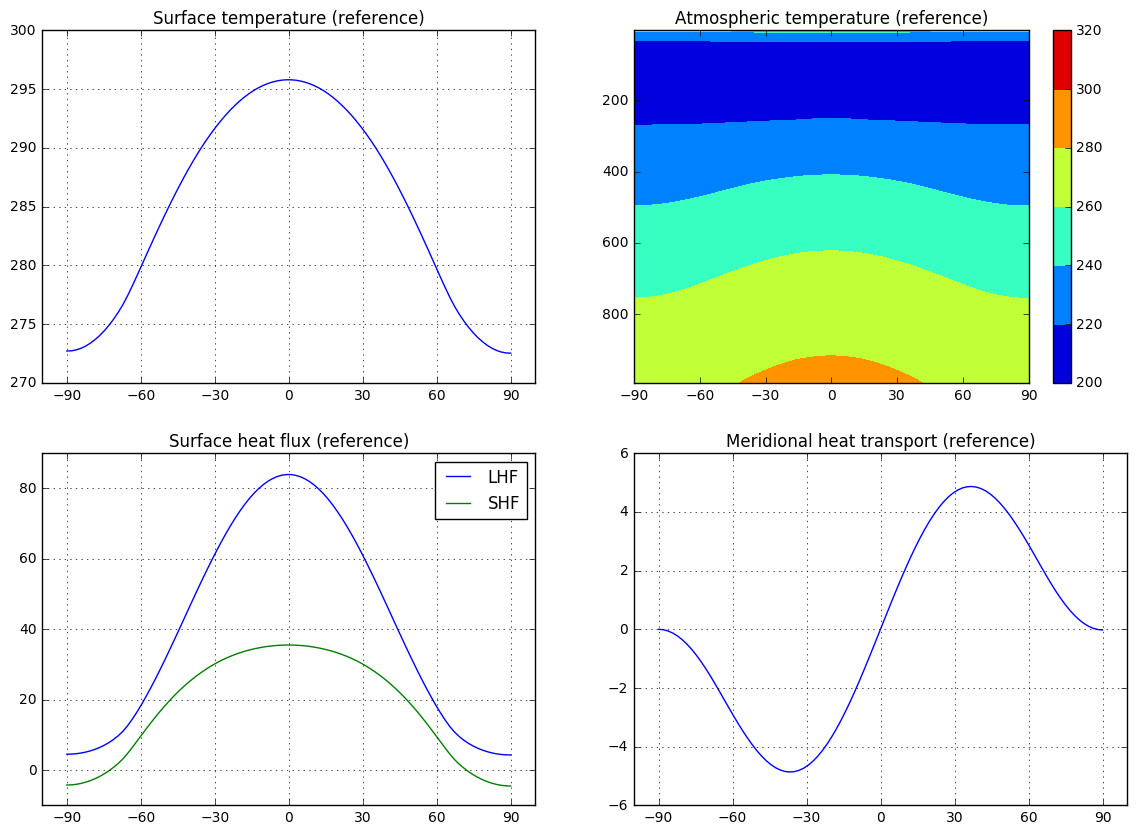

In [11]:
ticks = [-90, -60, -30, 0, 30, 60, 90]

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(2,2,1)
ax.plot(model.lat, model.Ts)
ax.set_xticks(ticks)
ax.grid();
ax.set_title('Surface temperature (reference)')

ax2 = fig.add_subplot(2, 2, 2)
field = (model.Tatm).transpose()
cax = ax2.contourf(model.lat, model.lev, field)
ax2.invert_yaxis()
ax2.set_xlim(-90,90)
ax2.set_xticks(ticks)
fig.colorbar(cax)
ax2.set_title('Atmospheric temperature (reference)');

ax3 = fig.add_subplot(2,2,3)
ax3.plot(lat, model.subprocess['LHF'].LHF, label='LHF')
ax3.plot(lat, model.subprocess['SHF'].SHF, label='SHF')
ax3.set_xticks(ticks)
ax3.grid();
ax3.set_title('Surface heat flux (reference)')
ax3.legend();

ax4 = fig.add_subplot(2,2,4)
Rtoa = np.squeeze(model.timeave['ASR'] - model.timeave['OLR'])
ax4.plot(model.lat, inferred_heat_transport(Rtoa, model.lat))
ax4.set_xticks(ticks)
ax4.grid();
ax4.set_title('Meridional heat transport (reference)');

###  Reducing the evaporation efficiency

Just need to clone our model, and modify $C_D$ in the latent heat flux subprocess.

In [12]:
model2 = climlab.process_like(model)
model2.subprocess['LHF'].Cd *= 0.5
model2.integrate_years(20.)

Integrating for 7304 steps, 7304.844 days, or 20.0 years.
Total elapsed time is 39.9953784092 years.


The global mean surface temperature anomaly is -0.11 K.


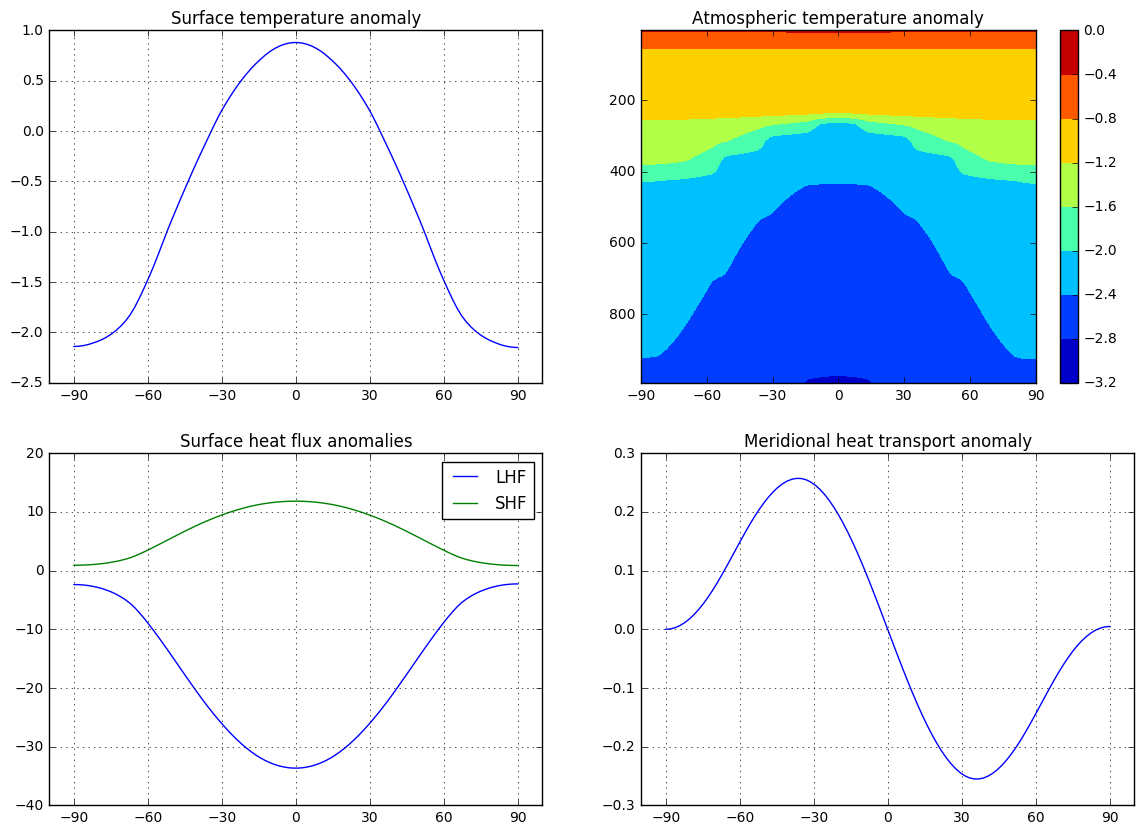

In [13]:
print ('The global mean surface temperature anomaly is %0.2f K.' 
       %np.average(model2.Ts - model.Ts, weights=np.cos(np.deg2rad(lat)), axis=0) )

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(2,2,1)
ax.plot(model.lat, model2.Ts - model.Ts)
ax.set_xticks(ticks)
ax.grid();
ax.set_title('Surface temperature anomaly')

ax2 = fig.add_subplot(2, 2, 2)
field = (model2.Tatm - model.Tatm).transpose()
cax = ax2.contourf(model.lat, model.lev, field)
ax2.invert_yaxis()
ax2.set_xlim(-90,90)
ax2.set_xticks(ticks)
fig.colorbar(cax)
ax2.set_title('Atmospheric temperature anomaly');

ax3 = fig.add_subplot(2,2,3)
ax3.plot(lat, model2.subprocess['LHF'].LHF - model.subprocess['LHF'].LHF, label='LHF')
ax3.plot(lat, model2.subprocess['SHF'].SHF - model.subprocess['SHF'].SHF, label='SHF')
ax3.set_xticks(ticks)
ax3.grid();
ax3.set_title('Surface heat flux anomalies')
ax3.legend();

ax4 = fig.add_subplot(2,2,4)
Rtoa = np.squeeze(model.timeave['ASR'] - model.timeave['OLR'])
Rtoa2 = np.squeeze(model2.timeave['ASR'] - model2.timeave['OLR'])
ax4.plot(model.lat, inferred_heat_transport(Rtoa2-Rtoa, model.lat))
ax4.set_xticks(ticks)
ax4.grid();
ax4.set_title('Meridional heat transport anomaly');

This model predicts the following:

- The **surface temperature** warms slightly in the tropics, and cools at high latitudes
- The **atmosphere** gets colder everywhere!
- There is a substantial reduction in surface latent heat flux, especially in the tropics where it is dominant.
- There is also a substantial **increase** in sensible heat flux. This is consistent with the cooler air temperatures and warmer surface.
- Colder tropical atmosphere leads to a decrease in the poleward heat tranpsort. This helps explain the high-latitude cooling.
- Notice that the heat transport responds to the **atmopsheric** temperature gradient, which changes in the opposite direction of the **surface** temperature gradient.

Basically, this model predicts that by inhibiting evaporation in the tropics, we force the tropical surface to warm and the tropical atmosphere to cool. This cooling signal is then communicated globally by atmospheric heat transport. The result is near-zero global temperature anomaly.

### Discussion: what is this model missing?

We could list many things, but as we will see below, two key climate components that are not included in this model are

- changes in relative humidity
- clouds

We will compare this result to an analogous experiment in a GCM.

____________
<a id='section3'></a>

## 3. Reduced evaporation efficiency experiment in an aquaplanet GCM
____________


The model is the familiar CESM but in simplified "aquaplanet" setup. The surface is completely covered by a shallow slab ocean.

This model setup (with CAM4 model physics) is described in detail in this paper:

> Rose, B. E. J., Armour, K. C., Battisti, D. S., Feldl, N., and Koll, D. D. B. (2014). The dependence of transient climate sensitivity and radiative feedbacks on the spatial pattern of ocean heat uptake. Geophys. Res. Lett., 41.

Here we will compare a control simulation with a perturbation simulation in which we have once again **reduced the drag coefficient by a factor of 2**.


In [14]:
# Load the zonally averaged climatologies from the CAM4 aquaplanet runs
ctrl = nc.Dataset(datapath + 'aquaplanet_som/QAqu_ctrl.cam.h0.zonclim.nc' + endstr)
halfEvap = nc.Dataset(datapath + 'aquaplanet_som/QAqu_halfEvap.cam.h0.zonclim.nc' + endstr)

In [15]:
lat = ctrl.variables['lat'][:]
lon = ctrl.variables['lon'][:]
lev = ctrl.variables['lev'][:]
time = halfEvap.variables['time'][:]

In [16]:
ctrl_clim = {}
halfEvap_clim = {}
anom_clim = {}
for varname in ctrl.variables:
    try:
        #field1 = np.mean(ctrl.variables[varname][60:, ...], axis=0)
        field1 = np.squeeze(ctrl.variables[varname][:])
        ctrl_clim[varname] = field1
        #field2 = np.mean(halfEvap.variables[varname][60:, ...], axis=0)
        field2 = np.squeeze(halfEvap.variables[varname][:])
        halfEvap_clim[varname] = field2
        anom_clim[varname] = field2 - field1
    except:
        pass

### Surface temperature anomaly

The global mean surface temperature anomaly is 4.38 K.


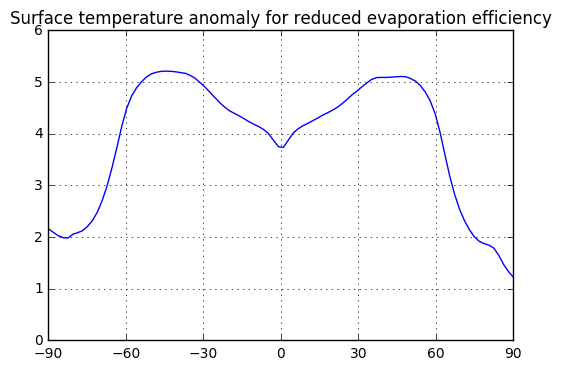

In [17]:
print ('The global mean surface temperature anomaly is %0.2f K.' 
        %np.average(anom_clim['TS'], weights=np.cos(np.deg2rad(lat))))

plt.plot(lat, anom_clim['TS'])
plt.xticks(ticks)
plt.xlim(-90,90)
plt.ylim(0, 6)
plt.grid()
plt.title('Surface temperature anomaly for reduced evaporation efficiency');

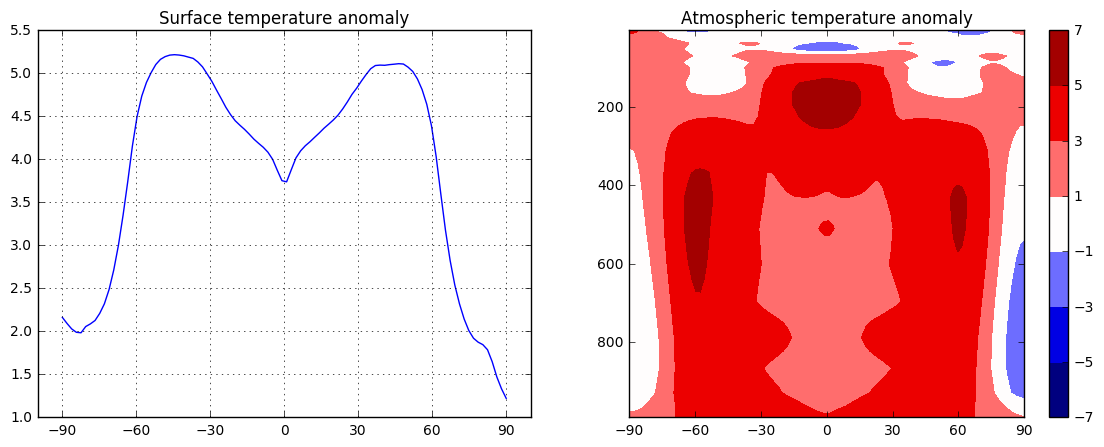

In [18]:
fig = plt.figure(figsize=(14,5))
ax = fig.add_subplot(1,2,1)
ax.plot(lat, anom_clim['TS'])
ax.set_xticks(ticks)
ax.grid();
ax.set_title('Surface temperature anomaly')

ax2 = fig.add_subplot(1, 2, 2)
cax2 = ax2.contourf(lat, lev, anom_clim['T'], levels=np.arange(-7, 8., 2.), cmap='seismic')
ax2.invert_yaxis()
ax2.set_xlim(-90,90)
ax2.set_xticks(ticks)
fig.colorbar(cax2)
ax2.set_title('Atmospheric temperature anomaly');



In this model, reducing the evaporation efficiency leads to a **much warmer climate**.  The largest warming occurs in mid-latitudes. The warming is **not** limited to the surface but in fact extends deeply through the troposphere.

Both the spatial pattern and the magnitude of the warming are completely different than what our much simpler model predicted.

Why?

### Compute all the terms in the TOA and surface energy and water budget anomalies


In [19]:
# TOA radiation
OLR = anom_clim['FLNT']
OLR_clr = anom_clim['FLNTC']
ASR = anom_clim['FSNT']
ASR_clr = anom_clim['FSNTC']
Rtoa = ASR - OLR  # net downwelling radiation
#  surface fluxes  (all positive UP)
LHF = anom_clim['LHFLX']  # latent heat flux (evaporation)
SHF = anom_clim['SHFLX'] # sensible heat flux
LWsfc = anom_clim['FLNS']  # net longwave radiation at surface
LWsfc_clr = anom_clim['FLNSC']  # net longwave radiation at surface (clear-sky)
SWsfc = -anom_clim['FSNS']  # net shortwave radiation at surface
SWsfc_clr = -anom_clim['FSNSC']  # net shortwave radiation at surface (clear-sky)
#  energy flux due to snowfall
SnowFlux =  (anom_clim['PRECSC'] + anom_clim['PRECSL'])*const.rho_w*const.Lhfus
#  hydrological cycle
Evap = anom_clim['QFLX']  # kg/m2/s or mm/s
Precip = (anom_clim['PRECC'][:] + anom_clim['PRECL'][:])*const.rho_w  # kg/m2/s or mm/s
EminusP = Evap - Precip  # kg/m2/s or mm/s
NetRadSfc = LWsfc + SWsfc  # net upward radiation from surface
NetSfc = NetRadSfc + LHF + SHF + SnowFlux  # net upward surface heat flux
Fatmin = Rtoa + NetSfc  # net heat flux in to atmosphere

### Energy budget anomalies at TOA and surface

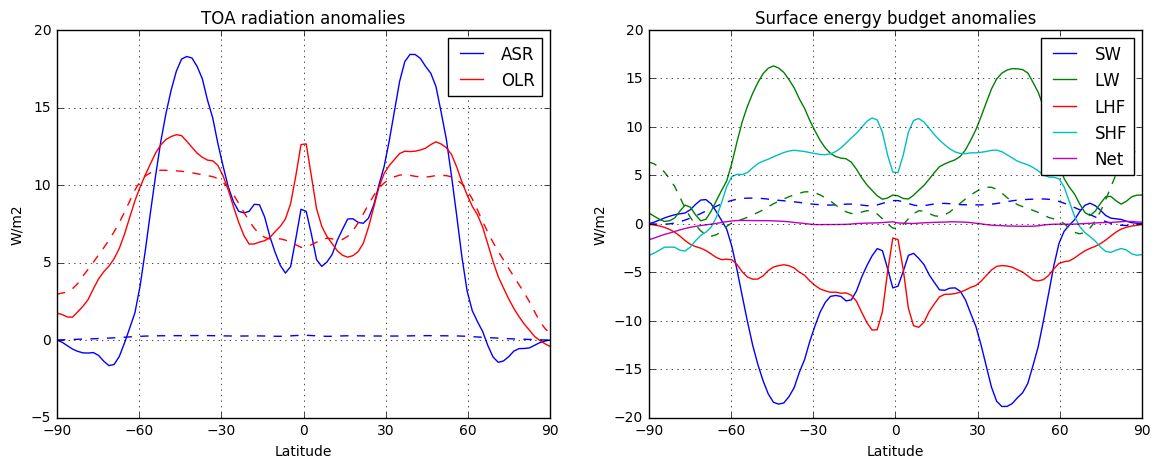

In [20]:
fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(lat, ASR, color='b', label='ASR')
ax1.plot(lat, OLR, color='r', label='OLR')
ax1.plot(lat, ASR_clr, color='b', linestyle='--')
ax1.plot(lat, OLR_clr, color='r', linestyle='--')
ax1.set_title('TOA radiation anomalies')
    
ax2 = fig.add_subplot(1,2,2)
ax2.plot(lat, SWsfc, color='b', label='SW')
ax2.plot(lat, SWsfc_clr, color='b', linestyle='--')
ax2.plot(lat, LWsfc, color='g', label='LW')
ax2.plot(lat, LWsfc_clr, color='g', linestyle='--')
ax2.plot(lat, LHF, color='r', label='LHF')
ax2.plot(lat, SHF, color='c', label='SHF')
ax2.plot(lat, NetSfc, color='m', label='Net')
ax2.set_title('Surface energy budget anomalies')

for ax in [ax1, ax2]:
    ax.set_ylabel('W/m2')
    ax.set_xlabel('Latitude')
    ax.set_xlim(-90,90)
    ax.set_xticks(ticks);
    ax.legend()
    ax.grid();

Dashed lines are **clear-sky** radiation anomalies.

Looking at the TOA budget:

- Reducing evaporation efficiency leads to very large increase in ASR, especially in mid-latitudes
- This increase is almost entirely due to clouds!
- Accompanied by a (mostly) clear-sky OLR increase, consistent with the warmer temperatures.

This is very suggestive of an important role for **low-level cloud changes**.  [Why?]

From the **surface budget**:

- Notice that the **decrease in evaporation is much weaker** than we found in the simple model.
- Here, the decreased evaporation **efficiency** is competing against the **warmer temperatures** which tend to strongly increase evaporation, all else being equal.
- The surface (ocean) gains a lot of excess heat by solar radiation.
- As noted from the TOA budget, this is **due to changes in cloudiness**.
- The clear-sky SW anomaly is actually positive, consistent with a warmer, moister atmosphere (but this effect is small).
- The LW anomaly is positive, indicating increased radiative cooling of the surface.
- This is also largely a cloud effect, and consistent with a **decrease in low-level cloudiness**. [Why?]
- As in the simple model, there is an **increase in the sensible heat flux** (though weaker).
- According to bulk formula, should be driven by one or both of
    - increased wind speed
    - increased air-sea temperature difference


###  Vertical structure of relative humidity and cloud changes

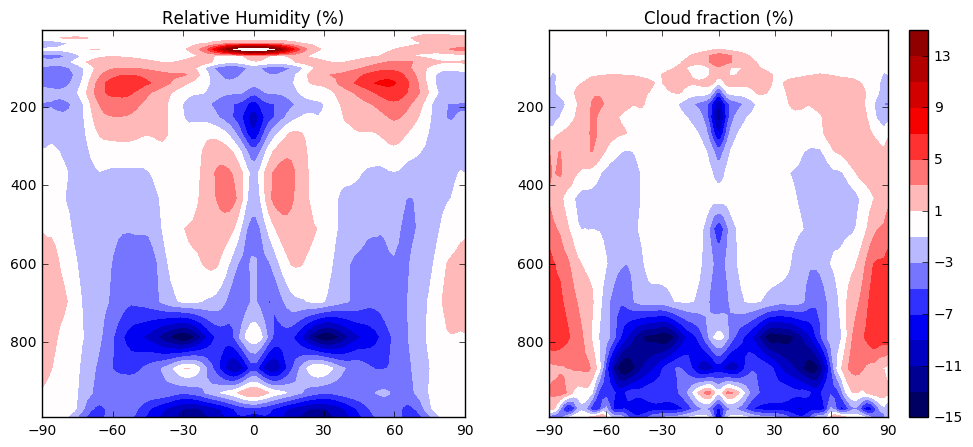

In [21]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
cax1 = ax1.contourf(lat, lev, anom_clim['RELHUM'], levels=np.arange(-15, 16., 2.), cmap='seismic')
ax1.set_title('Relative Humidity (%)')
ax2 = fig.add_subplot(1,2,2)
cax2 = ax2.contourf(lat, lev, 100*anom_clim['CLOUD'], levels=np.arange(-15, 16., 2.), cmap='seismic')
ax2.set_title('Cloud fraction (%)')
for ax in [ax1, ax2]:
    ax.invert_yaxis()
    ax.set_xlim(-90,90)
    ax.set_xticks(ticks);
fig.colorbar(cax1);

###  Meridional heat transport anomalies


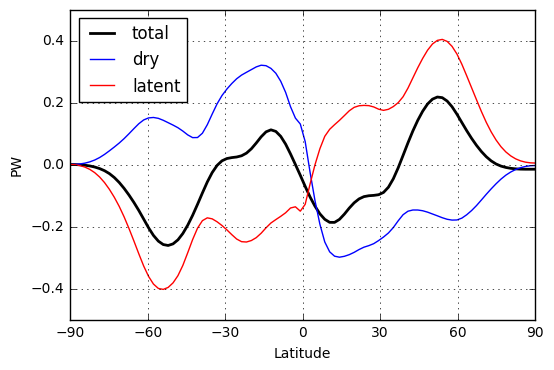

In [22]:
HT = {}
HT['total'] = inferred_heat_transport(Rtoa, lat)
HT['atm'] = inferred_heat_transport(Fatmin, lat)
HT['latent'] = inferred_heat_transport(EminusP * const.Lhvap, lat)
HT['dse'] = HT['atm'] - HT['latent']

fig, ax = plt.subplots()

ax.plot(lat, HT['total'], 'k-', label='total', linewidth=2)
ax.plot(lat, HT['dse'], 'b', label='dry')
ax.plot(lat, HT['latent'], 'r', label='latent')

ax.set_xlim(-90,90)
ax.set_xticks(ticks)
ax.legend(loc='upper left')
ax.grid()
ax.set_ylabel('PW')
ax.set_xlabel('Latitude')

____________
<a id='section4'></a>

## 4. Conclusion
____________



We have forced a climate change NOT by adding any kind of radiative forcing, but just by changing the efficiency of evaporation at the sea surface.

The climate system then find a new equilibrium in which the radiative fluxes, surface temperature, air-sea temperature difference, boundary layer relative humidity, and wind speeds all change simultaneously. 

Reasoning our way through such a problem from first principles in practically impossible. This is particularly true because in this example, the dominant driver of the climate change is an increase in SW absorption due to a substantial decrease in low-level clouds across the subtropics and mid-latitudes.

A comprehensive theory to explain these cloud changes does not yet exist. **Understanding changes in low-level cloudiness under climate change is enormously important** -- because these clouds, which have an unambiguous cooling effect, are a key determinant of climate sensitivity. There is lots of work left to do.

Water is intimately involved in just about every aspect of the planetary energy budget. Here we have highlighted the role of water in:

- Cooling of the surface by evaporation
- Water vapor greenhouse effect
- Poleward latent heat transport
- Cloud formation

<div class="alert alert-success">
[Back to ATM 623 notebook home](../index.ipynb)
</div>

____________
## Credits

The author of this notebook is [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It was developed in support of [ATM 623: Climate Modeling](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/), a graduate-level course in the [Department of Atmospheric and Envionmental Sciences](http://www.albany.edu/atmos/index.php), offered in Spring 2015.
____________

____________
## Version information
____________


In [23]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%version_information numpy, climlab

ERROR:root:Line magic function `%install_ext` not found.


Software versions
Python 2.7.12 64bit [GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]
IPython 5.1.0
OS Darwin 15.6.0 x86_64 i386 64bit
numpy 1.11.2
climlab 0.4.0
Tue Nov 01 17:21:00 2016 EDT